<a href="https://colab.research.google.com/github/rahiakela/transfer-learning-for-natural-language-processing/blob/main/2-getting-started-with-baselines/5_BERT_based_models_for_email_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT based models for Email Sentiment Classification

Our goal is to establish a set of baselines for a pair of concrete NLP problems, which we will later be able to use to measure progressive improvements gained from leveraging increasingly sophisticated transfer learning
approaches. In the process of doing this, we aim to advance your general NLP instincts and refresh your understanding of typical procedures involved in setting up problem-solving pipelines for such problems. You will review techniques ranging from tokenization to data structure and model selection. We first train some traditional machine learning models from scratch to establish some preliminary baselines for these problems.

We will focus on a pair of important representative example NLP problems – spam
classification of email, and sentiment classification of movie reviews. This exercise will arm you with a number of important skills, including some tips for obtaining, visualizing and preprocessing data. 

Three major model classes will be covered, namely linear models such as logistic regression, decision-tree-based models such as random forests, and neural-network-based models such as ELMo. These classes are additionally represented by support vector machines (SVMs) with linear kernels, gradient-boosting machines (GBMs) and BERT respectively. 

<img src='https://github.com/rahiakela/img-repo/blob/master/transfer-learning-for-natural-language-processing/content-classification-supervised-models.png?raw=1' width='800'/>



## Setup

Ref: https://stackoverflow.com/questions/57742410/error-on-scope-variable-while-using-tensorflow-hub

In [ ]:
%%shell

pip install keras==2.2.4 # critical dependency
pip install tensorflow==1.15
pip install "tensorflow_hub>=0.6.0"
pip install -q bert-tensorflow

In [2]:
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import email        # email package for processing email messages
import random
import re
import time
from tqdm import tqdm


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K

from bert.tokenization import FullTokenizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Initialize tensorflow session
sess = tf.Session()

In [4]:
from google.colab import files
files.upload() # upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahiakela","key":"484f91b2ebc194b0bff8ab8777c1ebff"}'}

In [5]:
%%shell

mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

# download dataset from kaggle
kaggle datasets download -d wcukierski/enron-email-dataset
unzip -qq enron-email-dataset.zip

kaggle datasets download -d rtatman/fraudulent-email-corpus
unzip -qq fraudulent-email-corpus.zip

rm -rf enron-email-dataset.zip fraudulent-email-corpus.zip

kaggle.json
 99% 356M/358M [00:15<00:00, 4.21MB/s]
100% 358M/358M [00:15<00:00, 24.6MB/s]
 91% 5.00M/5.52M [00:00<00:00, 7.45MB/s]
100% 5.52M/5.52M [00:00<00:00, 8.08MB/s]


In [6]:
def extract_messages(df):
  messages = []
  for item in df["message"]:
    # Return a message object structure from a string
    e = email.message_from_string(item)
    # get message body
    message_body = e.get_payload()
    messages.append(message_body)
  print("Successfully retrieved message body from e-mails!")
  return messages

## Preprocessing Email Spam Data

Here, we are interested in developing an algorithm that can detect whether any given email is spam or not, at scale. To do this, we will build a dataset from two separate sources – the popular Enron email corpus as a proxy for email that is not spam, and a collection of “419” fraudulent emails as a proxy for email that is spam.

We will view this as a supervised classification task, where we will first train a classifier on a collection of emails labeled as either spam or not spam. 

In particular, we will sample the Enron Corpus – the largest public email collection, related to the notorious Enron financial scandal – as a proxy for email that are not spam, and sample “419” fraudulent emails, representing the best known type of spam, as a proxy for email that is spam. Both of these types of emails are openly available on [Kaggle](https://www.kaggle.com/wcukierski/enron-email-dataset).

The Enron corpus contains about half a million emails written by employees of the Enron Corporation, as collected by the Federal Energy Commission for the purposes of investigating the collapse of the company. It has been used extensively in the literature to study machine learning methods for email applications and is often the first data source researchers working with emails look to for initial experimentation with algorithm prototypes. On Kaggle, it is
available as a single-column .csv file with one email per row. Note that this data is still cleaner than one can expect to typically find in many practical applications in the wild.

<img src='https://github.com/rahiakela/img-repo/blob/master/transfer-learning-for-natural-language-processing/spam-email-preprocessing.png?raw=1' width='800'/>

The body of the email will first be separated from the headers of the email, some statistics about the dataset will be teased out to get a sense for the data, stopwords will be removed from the email, and it will then be classified as either spam or not spam.

### Loading and Visualizing the Fraudulent Email Corpus

Let’s load the “419” fraudulent email corpus, so that we can have some example data in our training set representing the “spam” class.

> Since this dataset comes as a .txt file, versus a .csv, the preprocessing steps are slightly different. First
of all, we have to specify the encoding when reading the file as latin1, otherwise the default encoding option of
utf-8 will fail. It is often the case in practice that one needs to experiment with a number of different encodings,
with the aforementioned two being the most popular ones, to get some datasets to read correctly. Additionally,
note that because this .txt file is one big column of emails (with headers) separated by line breaks and white
space, and is not separated nicely into rows with one email per row – as was the case for the Enron corpus – we
can’t use Pandas to neatly load it as was done before. We will read all the emails into a single string, and split
the string on a code word that appears close to the beginning of each email’s header, i.e, “From r”.

In [7]:
filepath = "./fradulent_emails.txt"
with open(filepath, "r", encoding="latin1") as file:
  data = file.read()

Split on the code word From r appearing close to the beginning of each email

In [8]:
fraud_emails = data.split("From r")
print("Successfully loaded {} spam emails!".format(len(fraud_emails)))

Successfully loaded 3978 spam emails!


Now that the fraudulent data is loaded as a list, we can convert it into a Pandas DataFrame.

In [9]:
fraud_bodies = extract_messages(pd.DataFrame(fraud_emails, columns=["message"], dtype=str))
fraud_bodies_df = pd.DataFrame(fraud_bodies[1:])

fraud_bodies_df.head()

Successfully retrieved message body from e-mails!


,0
0,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,"Dear sir, \n \nIt is with a heart full of hope..."


### Loading and Visualizing the Enron Corpus

The first thing we need to do is load the data with the popular Pandas library, and to take a peek at a slice of the data to make sure we have a good sense of what it looks like.

In [10]:
filepath = "./emails.csv"

# Read the enron data into a pandas.DataFrame called emails
emails = pd.read_csv(filepath)
print("Successfully loaded {} rows and {} columns!".format(emails.shape[0], emails.shape[1]))
print(emails.head())

Successfully loaded 517401 rows and 2 columns!
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [11]:
# take a closer look at the first email
print(emails.loc[0]["message"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


We see that the messages are contained within the message column of the resulting DataFrame, with the extra fields at the beginning of each message – including Message ID, To, From, etc.,– being referred to as the message’s header information or simply header.

Traditional spam classification methods derive features from the header information for classifying the message as spam or not. Here, we would like to perform the same task based on the content of the message only. One possible motivation for this approach is the fact that email training data may often be de-identified in practice due to privacy concerns and regulations, thereby making header info unavailable. Thus, we need to separate the headers from the messages in our dataset.

In [12]:
bodies = extract_messages(emails)

Successfully retrieved message body from e-mails!


In [13]:
# We then can display some processed emails
bodies_df = pd.DataFrame(bodies)
print(bodies_df.head())

                                                   0
0                          Here is our forecast\n\n 
1  Traveling to have a business meeting takes the...
2                     test successful.  way to go!!!
3  Randy,\n\n Can you send me a schedule of the s...
4                Let's shoot for Tuesday at 11:45.  


In [14]:
# extract random 10000 enron email bodies for building dataset
bodies_df = pd.DataFrame(random.sample(bodies, 10000))

# expand default pandas display options to make emails more clearly visible when printed
pd.set_option("display.max_colwidth", 300)
# you could do print(bodies_df.head()), but Jupyter displays this nicer for pandas DataFrames
bodies_df.head()

,0
0,"Tracy,\n\nI have reconciled the detail file on these and no other ETS company is picking up the costs. I will be sending a detailed list of the companies to receive restricted stock with the final allocations on Wednesday.\n\nDawn\n\n -----Original Message-----\nFrom: \tGeaccone, Tracy \nSent:..."
1,"----- Forwarded by Tana Jones/HOU/ECT on 11/10/2000 09:04 AM -----\n\n\tBradley Diebner\n\t11/10/2000 07:54 AM\n\t\t \n\t\t To: Karen Lambert/HOU/ECT@ECT, Tana Jones/HOU/ECT@ECT, Samuel \nSchott/HOU/ECT@ECT, Mark Taylor/HOU/ECT@ECT, Brant Reves/HOU/ECT@ECT, Debbie \nR Brackett/HOU/ECT@ECT, David..."
2,Monika -\n\nI received some info today in the mail regarding a new master of science\nprogram in quantitative financial economics. It is being offered by\nOklahoma State University and they have a lot of money for financial\nsupport. Perhaps you should consider it.\n\nIf you send me your address...
3,"Dear class,\n\n1. Popular acclimation has requested that we move macro the exam to Thursday\n12/16. If you are one of the 3 people who prefered Wednesday, please contact \nme\nand we will arrange an opportunity for you to take the exam Wednesday.\n BA201B Thursday, 12/16 6-9:30 in C210 & ..."
4,per Jennifer Staton 6-6269


The following (commented out) code is arguably the more "pythonic" way of achieving the extraction of bodies from messages. It is only 2 lines long and achieves the same result.

In [ ]:
#messages = emails["message"].apply(email.message_from_string)
#bodies_df = messages.apply(lambda x: x.get_payload()).sample(10000)

### Email text preprocessing

Having loaded both datasets, we are now ready to sample emails from each one into a single DataFrame that will represent the overall dataset covering both classes of emails. Before doing this, we must decide how many samples to draw from each class. Ideally, the number of samples in each class will represent the natural distribution of emails in the wild, i.e, if we expect our classifier to encounter 60% spam emails and 40% nonspam emails when deployed, then a ratio such as 600 to 400 respectively might make sense.

**Note that a severe imbalance in the data, such as 99% for nonspam and 1% for spam may overfit to predict nonspam most of the time, an issue than needs to be considered when building datasets.** Since this is an idealized experiment, and we do not have any information on natural distributions of classes, we will
assume a 50/50 split. 

We also need to give some thought to how we are going to tokenize the emails, i.e., split emails into subunits of text - words, sentences, etc. To start off, we will tokenize into words, as this is the most common approach. 

We must also decide the maximum number of tokens per email, and the maximum length of each token, to ensure that the occasional “extremely long” email does not bog down the performance of our classifier. 

We do all these by specifying the following general hyperparameters, which will later be tuned experimentally to enhance performance as needed:

In [15]:
n_sample = 1000   # number of samples to generate in each class - 'spam', 'not spam'
maxtokens = 200    # the maximum number of tokens per document
maxtokenlen = 100  # the maximum length of each token

With these hyperparameters specified, we can now create a single DataFrame for the overarching training dataset. Let’s take the opportunity to also perform remaining preprocessing tasks, namely removing stop words, punctuations and tokenizing.

#### Tokenization

Let’s proceed by defining a function to tokenize emails by splitting them into words.

In [16]:
def tokenize(row):
  if row is None or row is "":
    tokens = ""
  else:
    tokens = str(row).split(" ")[:maxtokens]
  return tokens

#### Remove punctuation and unnecessary characters

Taking another look at the emails on the previous pair of pages, we see that they contain a lot of punctuation characters, and the spam emails tend to be capitalized. 

**In order to ensure that classification is done based on language content only, we have to remove punctuation marks and other non-word characters from the emails.** We do this by employing regular expressions with the Python regex library. We also normalize words by turning them into lower case.

In [17]:
def reg_expressions(row):
  tokens = []
  try:
    for token in row:
      token = token.lower()          # make all characters lower case
      token = re.sub(r"[\W\d]", "", token)
      token = token[:maxtokenlen]    # truncate all tokens to hyperparameter maxtokenlen
      tokens.append(token)
  except:
    token = ""
    tokens.append(token)
  return tokens

#### Stop-word removal

Finally, let’s define a function to remove stopwords - words that occur so frequently in language that they offer no useful information for classification. This includes words such as “the” and “are”, and the popular library NLTK provides a heavily used list that we will employ.

In [18]:
stop_words = stopwords.words("english")

def stop_word_removal(row):
  token = [token for token in row if token not in stop_words]
  token = filter(None, token)

  return token

### Assemble both Datasets

We are now going to put all these functions together to build the single dataset representing both classes. Most methods expect this dataset to be a Numpy array in order to process it, so we convert it to that form after combining the emails.

Now, putting all the preprocessing steps together we assemble our dataset...

In [19]:
# Convert everything to lower-case, truncate to maxtokens and truncate each token to maxtokenlen

# Apply predefined processing functions
enron_emails = bodies_df.iloc[:, 0].apply(tokenize)
enron_emails = enron_emails.apply(stop_word_removal)
enron_emails = enron_emails.apply(reg_expressions)
# sample the right number of emails from each class.
enron_emails = enron_emails.sample(n_sample)

# Apply predefined processing functions
spam_emails = fraud_bodies_df.iloc[:, 0].apply(tokenize)
spam_emails = spam_emails.apply(stop_word_removal)
spam_emails = spam_emails.apply(reg_expressions)
# sample the right number of emails from each class.
spam_emails = spam_emails.sample(n_sample)

# convert to Numpy array
raw_data = pd.concat([enron_emails, spam_emails], axis=0).values

Now, let’s take a peek at the result to make sure things are proceeding as expected:

In [20]:
print("Shape of combined data is:", raw_data.shape)
print("Data is:")
print(raw_data)

Shape of combined data is: (2000,)
Data is:
[list(['ercot', 'traderswe', 'going', 'live', 'curve', 'manager', 'ercot', 'monday', 'november', 'th', 'ercot', 'south', 'r', 'primary', 'curve', 'mark', 'others', 'dependent', 'upon', 'curve', 'i', 'know', 'first', 'days', 'learning', 'experience', 'ready', 'mark', 'curves', 'let', 'know', 'ill', 'come', 'sit', 'guysthanksandrea'])
 list(['teco', 'tap', '', '', 'enron', '', '', '', 'hpl', 'ifercls', 'hpl', 'lsk', 'ic', '', '', 'enron'])
 list(['', 'forwarded', 'darron', 'c', 'gironhouect', '', '', 'am', '', 'enron', 'north', 'america', 'corpfrom', 'darron', 'c', 'giron', '', '', 'amto', 'kristigironcfisdnetcc', 'subject', 'kids', 'find', 'contested', 'ballot', 'childs', 'play', 'forwarded', 'darron', 'c', 'gironhouect', '', '', 'am', 'greg', 'couch', '', 'pmto', 'darron', 'c', 'gironhouectect', 'david', 'lorenzcorpenronenroncc', 'subject', 'kids', 'find', 'contested', 'ballot', 'childs', 'play', 'forwarded', 'greg', 'couchhouect', '', '', 'p

We see that the resulting array has divided the text into word units, as we intended to.

Let’s create the headers corresponding to these emails, consisting of n_sample=1000 of spam emails followed by n_sample=1000 of non-spam emails:

In [21]:
categories = ["spam", "notspam"]
header = ([1] * n_sample)
header.extend(([0] * n_sample)) 

We are now ready to convert this Numpy array into numerical features that can actually be fed to the algorithms for classification.

### Converting the data to the form expected by Bert

Before using this function to train a model, we will need to adapt our preprocessed data a bit for this model architecture.

We use the below function to combine each such list into a single text string. This is the format in which the BERT TensorFlow hub model expects the input, and we are glad to oblige.

> **NOTE**: The combined string in this case has stopwords removed – steps that are often not required in deep learning practice due to the uncanny ability of artificial neural networks to figure out what is important and isn’t,
i.e., feature engineering, automatically. In our case, since we are trying to compare the strengths and weaknesses of the different model types for this problem, applying the same kind of preprocessing for all algorithms makes sense and is arguably the right approach. We note however that ELMo was pretrained on a corpus containing stopwords, as was BERT.

Having fully vectorized the dataset, we must remember that it is not shuffled with respect to classes, i.e., it contains Nsamp = 1000 spam emails followed by an equal number of nonspam emails. Depending on how this dataset is split, in our case by picking the first 70% for training and the remainder for testing, this could lead to a training set composed of spam only, which would obviously lead to failure. In order to create a randomized ordering of class samples in the dataset, we will need to shuffle the data in unison with the header/list of labels.


In [22]:
# shuffle raw data first
def unison_shuffle_data(data, header):
  p = np.random.permutation(len(header))
  data = data[p]
  header = np.asarray(header)[p]

  return data, header

In [23]:
# we expect a single string per email here, versus a list of tokens for the sklearn models previously explored
def convert_data(raw_data, header):
  converted_data, labels = [], []
  for i in range(raw_data.shape[0]):
    # combine list of tokens representing each email into single string
    out = " ".join(raw_data[i])
    converted_data.append(out)
    labels.append(header[i])
  converted_data = np.array(converted_data, dtype=object)[:, np.newaxis]

  return converted_data, np.array(labels)

As the very last step of preparing the email dataset for training by our baseline classifiers, we split it into independent training and testing or validation sets. This will allow us to evaluate the performance of the classifier on a set of data that was not used for training, an important thing
to ensure in machine learning practice. We elect to use 70% of the data for training, and 30% for testing/validation afterwards.

In [24]:
raw_data, header = unison_shuffle_data(raw_data, header)

# split into independent 70% training and 30% testing sets
idx = int(0.7 * raw_data.shape[0])  # get 70% index value

# 70% of data for training
train_x, train_y = convert_data(raw_data[:idx], header[:idx])

# remaining 30% for testing
test_x, test_y = convert_data(raw_data[idx:], header[idx:])

print("train_x/train_y list details, to make sure they are of the right form:")
print(len(train_x))
print(train_x)
print(len(train_y))
print(train_y[:5])

train_x/train_y list details, to make sure they are of the right form:
1400
[['dear friendthrough the courtesy of business opportunity i take liberty anchored on astrong desire to solicit your assistance on this mutually beneficial andriskfree transaction which i hope you will give your urgent attentioni am mrsesay massaquoe i am moved to write you this letter this was inconfidence considering our present circumstance and situationi escaped with my wife and children out of sierra leone togroujirnssuma village in the netherlands through the aid of the unitednations evacuation team where we are now presently residing on temporarypolitical asylumhowever due to this situation i decided to change most of my billions ofdollars deposited in swiss bank and other countries into other forms ofmoney coded for safe purpose because the new head of states ahmed tejankabba made arrangements with the swiss government and other europeancountries to freeze all my treasures deposited in some europeancoun

Since 70% of 2000 is 1400, looks good! (for n_sample=1000)

## Neural Network Models

Neural networks are the most important class of machine learning algorithms for handling perceptual problems such as computer vision and NLP.

we will train two representative pretrained neural network language models
on the two illustrative example problems we have been baselining.

The two models we will consider here are:

- **ELMo** – Embeddings from Language Models, and
- **BERT** – Bidirectional Encoder Representations from Transformers.

ELMo includes elements of convolutional and recurrent (specifically LSTM) elements, while the appropriately named BERT is transformer-based.

The simplest form of transfer learning fine-tuning will be employed, where a single dense classification layer is trained on top of the corresponding pretrained embedding over our dataset of labels.


### Bidirectional Encoder Representations from Transformers (BERT)

**Bidirectional Encoder Representations from Transformers (BERT) model** was also named after a popular Sesame Street character as a nod to the trend started by ELMo. BERT variants achieve some of the best performance in transferring pretrained language model knowledge to downstream NLP tasks. The model was similarly trained to predict words in a sequence of words, although the exact masking procedure is somewhat different. It can also be done in an unsupervised manner on very large corpuses, and the resulting weights similarly
generalize to a variety of other NLP tasks. **Arguably, to familiarize oneself with transfer learning in NLP, it is indispensable for one to familiarize oneself with BERT.**

It will suffice to mention here that the model employs character-level convolutions to build up preliminary embeddings of word tokens, followed by transformer-based encoders with selfattention layers that provide the model with a context of surrounding words. **The transformer functionally replaced the role of the bidirectional LSTMs employed by ELMo. Transformers have some advantages versus LSTMs with respect to training scalability as well.**. Again, we will use Keras with Tensorflow backend to build our model.


### Define BERT layer

The BERT model is also available through the Tensorflow Hub. In order to
make the hub model usable by Keras, we similarly define a custom Keras layer that instantiates it in the right format.

In [25]:
class BertLayer(tf.keras.layers.Layer):

  def __init__(self, n_fine_tune_layers=10, pooling="mean", bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1", **kwargs):
    self.n_fine_tune_layers = n_fine_tune_layers    # Default number of top layers to unfreeze for training
    self.trainable = True
    self.output_size = 768      # BERT embedding dimension, i.e., size of resulting output semantic vectors
    self.pooling = pooling      # Choice of regularization type
    self.bert_path = bert_path  # Pretrained model to use, this is the large uncased original version of the model

    if self.pooling not in ["first", "mean"]:
      raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

    super(BertLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    """function for building BERT embedding"""
    # Download pretrained BERT model from Tensorflow Hub
    self.bert = hub.Module(self.bert_path, trainable=self.trainable, name=f"{self.name}_module") 

    # Remove unused layers
    trainable_vars = self.bert.variables
    if self.pooling == "first":
      trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
      trainable_vars = ["pooler/dense"]
    elif self.pooling == "mean":
      trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name and not "/pooler/" in var.name]
      trainable_vars = []
    else:
      raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")
    
    # Select how many layers to fine tune
    for i in range(self.n_fine_tune_layers):
      trainable_layers.append(f"encoder/layer_{str(11 - i)}")

    # Update trainable vars to contain only the specified layers
    trainable_vars = [var for var in trainable_vars if any([layer in var.name for layer in trainable_vars])]

    # Add to trainable weights
    for var in trainable_vars:
      self._trainable_weights.append(var)

    for var in self.bert.variables:
      if var not in self._trainable_weights:
        self._non_trainable_weights.append(var)

    super(BertLayer, self).build(input_shape)

  def call(self, inputs):
    """specify function for calling embedding"""
    inputs = [K.cast(x, dtype="int32") for x in inputs]
    input_ids, input_mask, segment_ids = inputs
    # Inputs to BERT take a very specific triplet form
    bert_inputs = dict(
        input_ids = input_ids,
        input_mask = input_mask,
        segment_ids = segment_ids
    )
    
    if self.pooling == "first":
      pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)["pooled_output"]
    elif self.pooling == "mean":
      result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)["sequence_output"]
      # BERT “masks” some words and then attempts to predict them as learning target
      mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
      masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
      input_mask = tf.cast(input_mask, tf.float32)
      pooled = masked_reduce_mean(result, input_mask)
    else:
      raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

    return pooled

  def compute_output_shape(self, input_shape):
    """specify output shape"""
    return (input_shape[0], self.output_size)

### Build BERT model

We now use the custom TF hub ELMo embedding layer within a higher-level function to define the overall model. More specifically, we put a dense trainable layer of output dimension 256 on top of the ELMo embedding.

In [ ]:
def build_model():
  input_text = layers.Input(shape=(1,), dtype="string")
  embedding = ElmoEmbeddingLayer()(input_text)
  dense = layers.Dense(256, activation="relu")(embedding)      # new layer outputting 256-dimensional feature vectors
  prediction = layers.Dense(1, activation="sigmoid")(dense)

  # we could use sigmoid activation as well, but we choose softmax
  # to enable us use sparse_categorical_crossentropy and sparse_categorical_accuracy below
  model = Model(inputs=[input_text], outputs=prediction)
  # use sparse_categorical_crossentropy and sparse_categorical_accuracy do avoid having to one-hot encode the labels
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  model.summary()

  return model

In [ ]:
# Build and fit
model = build_model()
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=5, batch_size=32)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 262,661
Trainable params: 262,661
Non-trainable params: 0
_________________________________________________________________



Train on 1400 samples, validate on 600 samples
Epoch 1/5



1400/1400 [==============================] - 79s 57ms/step - loss: 0.3709 - acc: 0.8779 - val_loss: 0.1038 - val_acc: 0.9883
Epoch 2/5
1400/1400 [==============================] - 36s 25ms/step - loss: 0.3254 - acc: 0.9343 - val_loss: 0.1393 - val_acc: 0.9650
Epoch 3/5
1400/1400 [==============================] - 35s 25ms/step - loss: 0.1886 - acc: 0.9621 - val_loss: 0.1262 - val_acc: 0.9583
Epoch 4/5
1400/1400 [==============================] - 35s 25ms/step - loss: 0.0696 - acc: 0.9850 - val_loss: 0.0405 - val_acc: 0.9917
Epoch 5/5
1400/1400 [==============================] - 35s 25ms/step - loss: 0.0931 - acc: 0.9850 - val_loss: 0.0593 - val_acc: 0.9883


In [ ]:
# Save trained model
model.save("ELMoModel.h5")

First of all, notice that we have added an additional layer on top the pretrained ELMo embedding, producing 256-dimensional feature vectors. We have also added a classification layer of output dimension 1. The activation function ‘sigmoid’ transforms its input into the interval between 0 and 1.

Its output can be interpreted as the probability of the positive class, and when it exceeds some prespecified threshold (usually 0.5) the corresponding input to the network can be classified as the said positive class.

We note that most of the trainable parameters in this case (approximately 260 thousand of them) are coming from the layers we added on top of the custom ELMo model. In other words, this is our first instance of transfer learning – learning a pair of new layers on top of the pretrained model shared by ELMo’s creators.

In practice, one can increase the value of this parameter until the speed of convergence of a typical problem instance does not benefit from the increase, or whenever the GPU memory is no longer large enough for a single data batch to
fit on it during an iteration of the algorithm, whichever happens first. Additionally, when dealing with a multi-GPU scenario, some evidence that the optimal scaling-up schedule of the batch size is linear in the number of GPUs, has been presented.

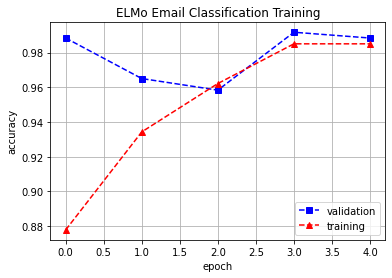

In [ ]:
df_history = pd.DataFrame(history.history)

fig,ax = plt.subplots()
plt.plot(range(df_history.shape[0]),df_history['val_acc'],'bs--',label='validation')
plt.plot(range(df_history.shape[0]),df_history['acc'],'r^--',label='training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('ELMo Email Classification Training')
plt.legend(loc='best')
plt.grid()
plt.show()
# Save figures
fig.savefig('ELMoConvergence.eps', format='eps')
fig.savefig('ELMoConvergence.pdf', format='pdf')
fig.savefig('ELMoConvergence.png', format='png')
fig.savefig('ELMoConvergence.svg', format='svg')

We see that a validation accuracy of approximately 98.83% is attained at the 4th epoch, i.e., in under a minute. This performance is comparable to the performance of the logistic regression approach, which is only slightly better at 98.8%. We note that the behavior of the algorithm is stochastic, i.e., it behaves differently from run to run.

Finally, we note that the divergence of training and validation accuracies is suggestive of the beginning of overfitting as indicative in the figure. This
lends credence to the hypothesis that increasing the amount of signal by increasing the length of tokens, as specified by hyper-parameter maxtokenlen, and the number of tokens per email, as specified by maxtokens, may increase performance further. Naturally, increasing the number of samples per class by cranking up Nsamp should also work to improve performance.

Each epoch again takes approximately 10 seconds and a validation accuracy of approximately 70% is achieved in under a minute at the 2nd epoch.

**Note that some evidence of overfitting can be observed at the 3rd and later epochs, as the training accuracy continues to improve, i.e., the fit to the data improves, while the validation accuracy remains lower.**